# 0. Imports

In [57]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
# plt.style.use("seaborn")
plt.style.use("dark_background")
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
plt.rc('figure', figsize=(16,10))
plt.rc('lines', markersize=4)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy as sc
import yfinance as yf
from sqlite3 import connect as sqlconnect

# 1. Data

## 1.1 Importing 

In [17]:
tickers = ['GOOG']
df = yf.download(tickers=tickers,  group_by=tickers)

[*********************100%***********************]  1 of 1 completed


In [20]:
def save_df(df:pd.DataFrame, table_name:str='stock_price') -> None:
    '''Saves the dataframe df, assuming is a timeseries in an sqlite3 database in the root folder.
    '''
    with (conn:= sqlconnect(f'{table_name}.db')):
        df.reset_index().to_sql(table_name, conn, if_exists='replace', index=False) # writes to file
    conn.close()

In [21]:
save_df(df=df)

In [3]:
def load_df(table_name:str='stock_price') -> pd.DataFrame:
    '''Loads the dataframe df, saved in stock_price.db. Assumes that the dataframe is in time series form.
    '''
    with (conn := sqlconnect(f'{table_name}.db')):
        df = pd.read_sql(f'select * from {table_name}', conn, index_col='Date', parse_dates=['Date'])
    conn.close()
    return df

In [4]:
df = load_df()

In [5]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
...,...,...,...,...,...,...
2022-10-11,98.250000,100.120003,97.250000,98.050003,98.050003,21617700
2022-10-12,98.269997,99.648003,97.669998,98.300003,98.300003,17343400
2022-10-13,95.930000,100.529999,95.269997,99.709999,99.709999,32812200


General info

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4573 entries, 2004-08-19 to 2022-10-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4573 non-null   float64
 1   High       4573 non-null   float64
 2   Low        4573 non-null   float64
 3   Close      4573 non-null   float64
 4   Adj Close  4573 non-null   float64
 5   Volume     4573 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 250.1 KB


No NaN or null values

In [7]:
df.isnull().values.any()
df.isna().values.any()

False

False

Max/Min dates

In [8]:
df.index.min()

Timestamp('2004-08-19 00:00:00')

In [9]:
df.index.max()

Timestamp('2022-10-17 00:00:00')

Total period

In [10]:
df.index.max()-df.index.min()

Timedelta('6633 days 00:00:00')

## 1.2 Exploratory Data Analysis

In [11]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4.573000e+03
mean,36.972466,37.348427,36.597647,36.978924,36.978924,1.247034e+08
std,34.890275,35.267642,34.526379,34.898448,34.898448,1.540179e+08
min,2.470490,2.534002,2.390042,2.490913,2.490913,1.584340e+05
25%,12.514592,12.661292,12.371379,12.524057,12.524057,3.021800e+07
50%,22.396303,22.565170,22.301409,22.488209,22.488209,6.956778e+07
75%,52.825500,53.466499,52.261501,52.831001,52.831001,1.563438e+08
max,151.863495,152.100006,149.887497,150.709000,150.709000,1.650833e+09


In [12]:
df.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999907,0.999894,0.999784,0.999784,-0.460903
High,0.999907,1.000000,0.999868,0.999894,0.999894,-0.459851
Low,0.999894,0.999868,1.000000,0.999905,0.999905,-0.462402
Close,0.999784,0.999894,0.999905,1.000000,1.000000,-0.461276
Adj Close,0.999784,0.999894,0.999905,1.000000,1.000000,-0.461276
Volume,-0.460903,-0.459851,-0.462402,-0.461276,-0.461276,1.000000


Let's probe the OHLC correlation

Pretty much all OHLC is almost perfectly correlated. Which means we could use Open prices as the independent variable X and try to predict the Close price y. 
- This is obviously not the best choice since in a real scenario we would be able to predict the Close price once we have the latest Open price.
- Other more efficient ways are using technical indicators as X. We will persue one such case later.

<AxesSubplot:xlabel='Open', ylabel='Close'>

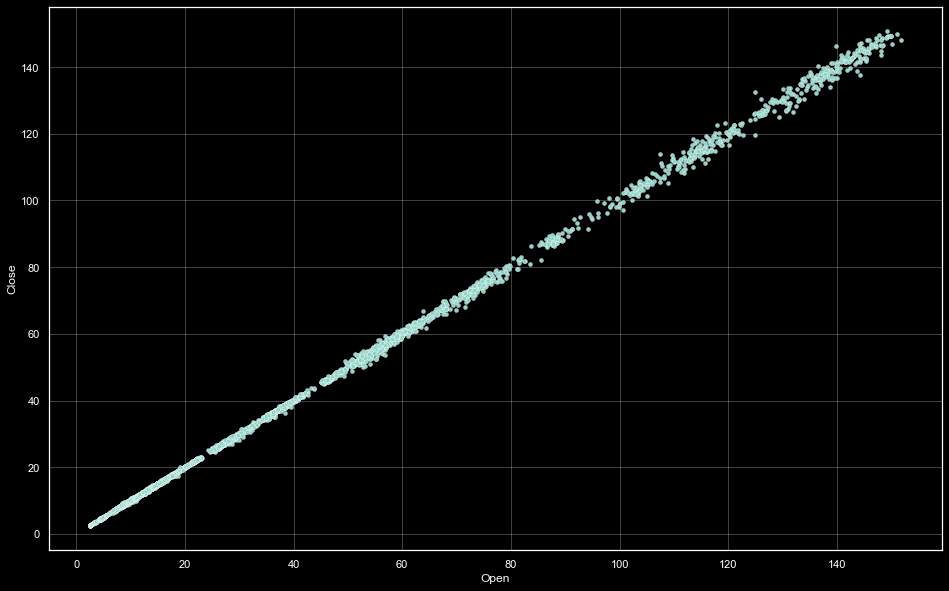

In [13]:
sns.scatterplot(x=df['Open'], y=df['Close'])

Open and Close prices are indeed linearly related.

# 2 Preparing training data (Open Price)

The Close price will be chosen as the dependent variable y

In [14]:
y = df.loc[:, df.columns.get_level_values(0) == 'Close'] #this is to ensure a 2-D array later on, as opposed to just df['Close'] which results in 1-D array
y.values 

array([[  2.49913311],
       [  2.69763899],
       [  2.724787  ],
       ...,
       [ 99.70999908],
       [ 97.18000031],
       [100.77999878]])

As for the independent variable X there are numerous choices. 

- A common practice is choosing some technical indicator like moving averages. We will test a technical indicator later.
- Nonetheless we will chose the Open prices as X since there is 0.999784 correlation and they are linearly related. 

In [15]:
X = df.loc[:, df.columns.get_level_values(0) == 'Open'] #this is to ensure a 2-D array later on, as opposed to just df['Open'] which results in 1-D array
X.values

array([[  2.49066401],
       [  2.51582003],
       [  2.75841093],
       ...,
       [ 95.93000031],
       [100.625     ],
       [ 99.51999664]])

We separate the data into train and test parts with 30% being the test part.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

Text(0.5, 1.0, 'Train Close and Open Prices')

<AxesSubplot:title={'center':'Train Close and Open Prices'}, xlabel='Open', ylabel='Close'>

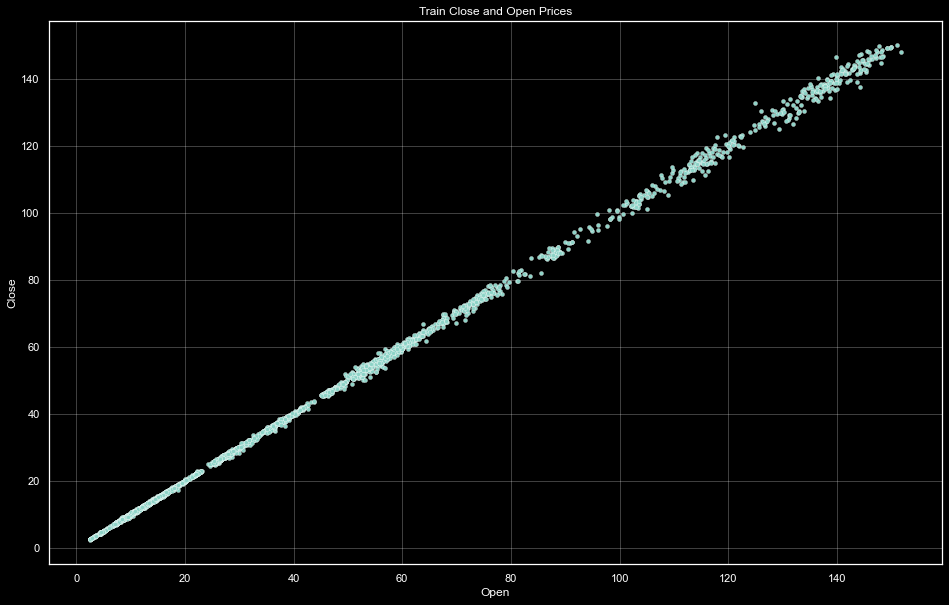

In [44]:
plt.title('Train Close and Open Prices')
sns.scatterplot(x=X_train['Open'], y=y_train['Close'], edgecolor='w')

Text(0.5, 1.0, 'Test Close and Open Prices')

<AxesSubplot:title={'center':'Test Close and Open Prices'}, xlabel='Open', ylabel='Close'>

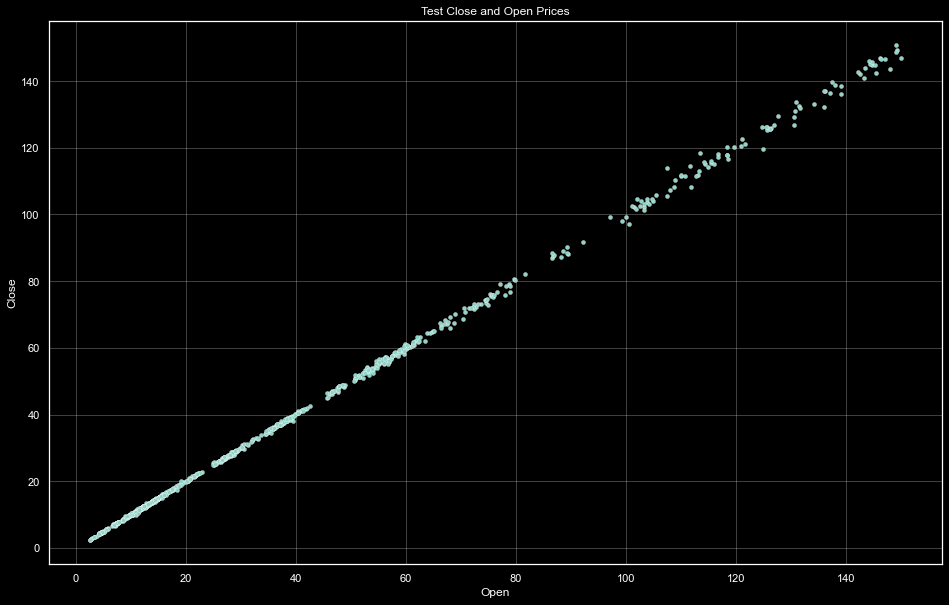

In [45]:
plt.title('Test Close and Open Prices')
sns.scatterplot(x=X_test['Open'], y=y_test['Close'], edgecolor='w')

The linearity is still consistent and evident after training and spliting the dataset.

# 3. Model

## 3.1 Theory

The model in our case will be Simple Linear Regression since
- Only one dependent variable has been chosen y (Close prices). This is also what we are trying to predict.
- Only one independent variable has been chose X (Open prices).
- There is an obvious linear relation between the Close and Open prices.

The formula for the straight line is:
$$ y = \lambda X + b $$

where

- $ y $ dependent variable to be predicted
- $ b $ is the y-intercept
- $ \lambda $ is the slope
- $ X $ is the independent variable

The plan is to find $ \lambda $ and $ b $ such that we realize the best fitted line through the datapoints. The term best fitted will be achieved, in general, by minimizing the sum of the squared errors from the test points and the actual predicted points.

## 3.2 Instatiating the model

In [46]:
model = LinearRegression(copy_X=True)

In [47]:
model.fit(X_train, y_train)

LinearRegression()

In [48]:
mini_summary = f'''
There were n = {model.n_features_in_} features, with names: {model.feature_names_in_} in the model: {model}.
The Slope calculated is {model.coef_.flatten()}.
The Intercept calculated is {model.intercept_}.
'''
print(mini_summary)


There were n = 1 features, with names: ['Open'] in the model: LinearRegression().
The Slope calculated is [1.00021078].
The Intercept calculated is [0.00290867].



Interpretation

- The slope coefficient translates a 1 unit increase of Open price into 1.0005142 units of increase in Close price. This high value was kind of expected to due the almost perfect correlation of Open and Close prices.
- The intercept coefficient has no significance in this case. One may interpret is as the Close price when the Open price was 0. However there is no 0 Open price yet.

In [49]:
y_pred = pd.DataFrame(model.predict(X_test), columns=y_test.columns, index=y_test.index)
y_pred

,Close
Date,
2011-10-03,12.704238
2012-03-26,16.071080
2020-03-23,53.080096
2015-09-02,30.288790
2018-09-04,60.229101
...,...
2011-05-31,13.081653
2020-04-30,66.260875
2015-02-02,26.522203


<AxesSubplot:xlabel='Date', ylabel='Close'>

<AxesSubplot:xlabel='Date', ylabel='Close'>

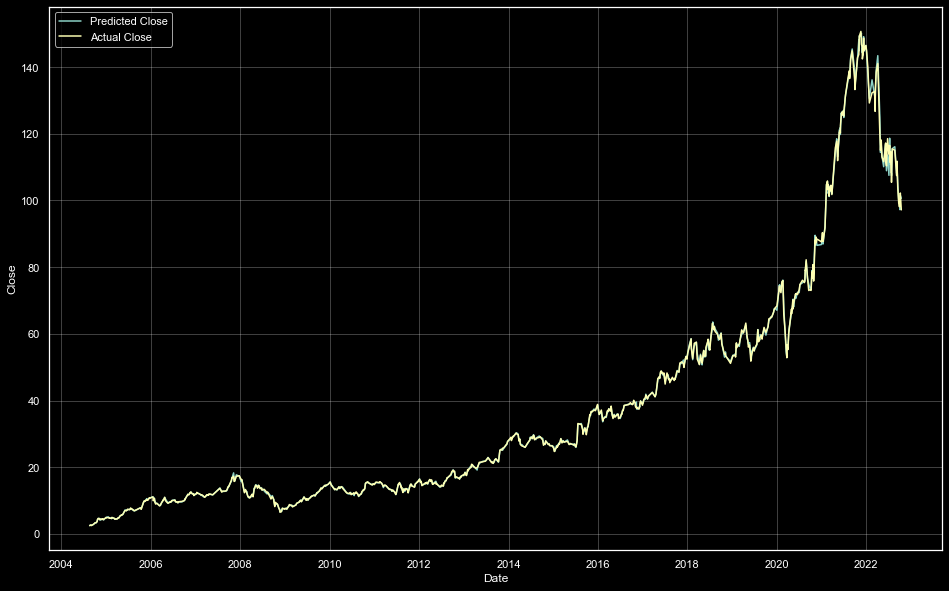

In [50]:
sns.lineplot(x=y_pred.index, y=y_pred['Close'], label='Predicted Close')
sns.lineplot(x=y_pred.index, y=y_test['Close'], label='Actual Close')

# 4. Model Evaluation

## 4.1 Error Evaluation metric

For the purposes of this project only the Root Mean Squared Error(RMSE) will be needed.

RMSE is the square root of the mean of the squared errors defined as:
$$ RMSE = \sqrt{\dfrac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2} $$

In [51]:
RMSE = np.sqrt(mean_squared_error(y_test,y_pred))
RMSE

0.6936359654691538

which is negligible 

In [52]:
RMSE/df[['Open', 'Close']].describe().loc['mean']

Open     0.018761
Close    0.018758
Name: mean, dtype: float64

compared to the mean in

In [53]:
df[['Open', 'Close']].describe()

,Open,Close
count,4573.000000,4573.000000
mean,36.972466,36.978924
std,34.890275,34.898448
min,2.470490,2.490913
25%,12.514592,12.524057
50%,22.396303,22.488209
75%,52.825500,52.831001
max,151.863495,150.709000


## 4.2 Accuracy Evaluation metric

It represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance.

The range of values of the Coefficient of determination is $ 0 \leq R^2 \leq 1 $.

RSS is defined as $$ R^2 =  1 - \dfrac{RSS}{TSS} $$

where:

- Residual Sum of Squares:
$$ RSS = \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 $$

- Total Sum of Squares:
$$ TSS = \sum_{i=1}^{N} (y_i - \bar{y}_i)^2 $$

- $\hat y_i$ is the predicted value of the i-th sample
- $y_i$ is the corresponding true value for i-th sample

In [54]:
r2_score(y_test, y_pred)

0.99961145348061

which means that all variance of y(Close Prices) is explained by X(Open Prices).

Let us plot the Residuals

<AxesSubplot:xlabel='Close', ylabel='Close'>

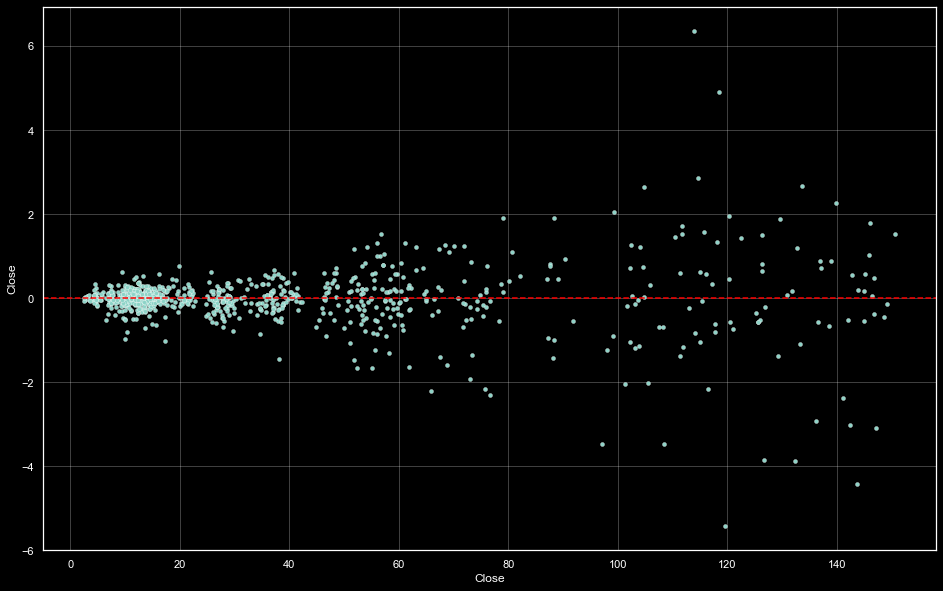

In [63]:
test_residuals = (y_test - y_pred)
sns.scatterplot(x=y_test['Close'], y=test_residuals['Close'])
plt.axhline(y=0, color='red', ls='--', label='Normality')

- y=0 denotes the normal distribution
- the points are more or less randomly distributed around y=0, as they should

This can also be seen in a probability plot, where the red line denotes normality.

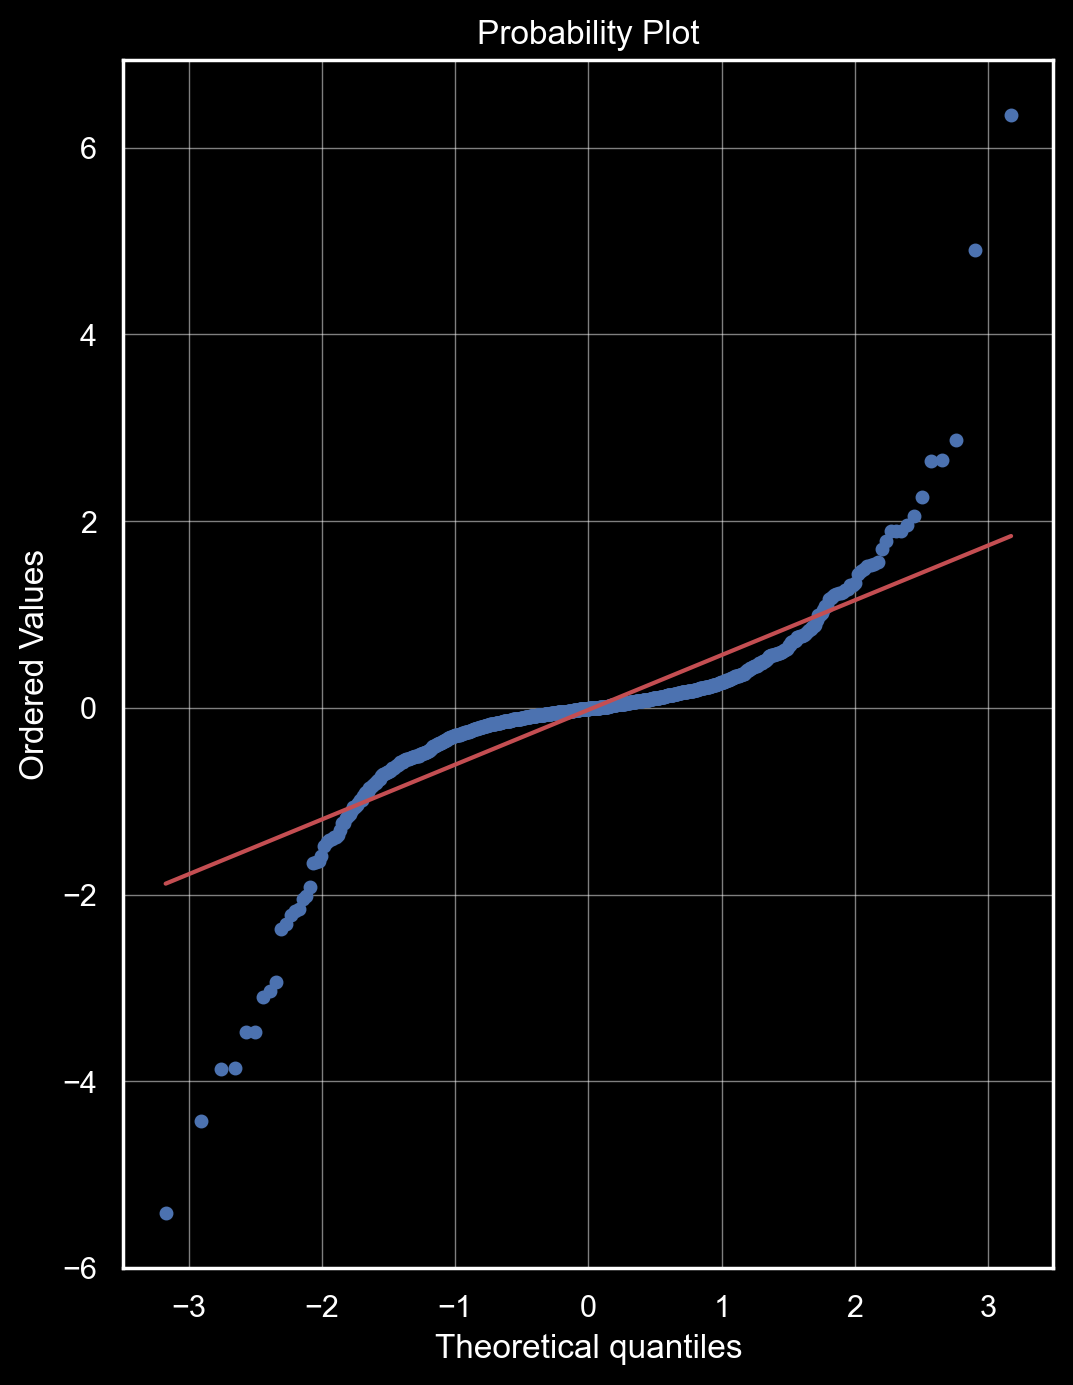

In [61]:
fig, ax = plt.subplots(figsize=(6,8),dpi=200)
_ = sc.stats.probplot(test_residuals['Close'], plot=ax)

Finally, the departure of normality is evident also from the histogram of the residuals

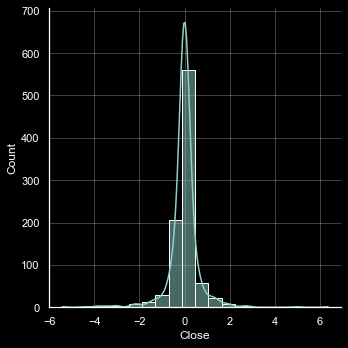

In [62]:
sns.displot(test_residuals['Close'], kde=True, bins=20)